In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your dataset directory
# Adjust this path to where your dataset is located in Google Drive
DATASET_PATH = '/content/drive/MyDrive/Indian_Sign_Language'

import os
print("Dataset directory contents:")
print(os.listdir(DATASET_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory contents:
['which', 'skin', 'secondary', 'small', 'stand', 'today', 'warn', 'specific', 'work', 'you', 'pray', 'doctor', 'from', 'become', 'pain', 'agree', 'college', 'bad', 'assistance', 'afraid']


Total sign categories found: 20
Sample categories: ['which', 'skin', 'secondary', 'small', 'stand', 'today', 'warn', 'specific', 'work', 'you']

Users for category 'which': ['User_1', 'User_2', 'User_3']
Number of images for first user: 150
Sample image names: ['which1_User1_1.jpg', 'which10_User1_10.jpg', 'which103_User1_103.jpg', 'which102_User1_102.jpg', 'which108_User1_108.jpg']


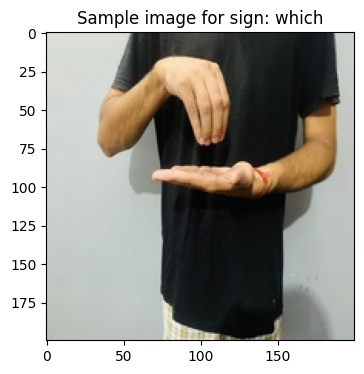

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def explore_dataset(dataset_path):
    # Get all word categories
    categories = os.listdir(dataset_path)
    categories = [cat for cat in categories if os.path.isdir(os.path.join(dataset_path, cat))]

    print(f"Total sign categories found: {len(categories)}")
    print(f"Sample categories: {categories[:10]}")

    # Check structure for first category
    first_category = categories[0]
    first_category_path = os.path.join(dataset_path, first_category)
    users = os.listdir(first_category_path)
    print(f"\nUsers for category '{first_category}': {users}")

    # Check number of images for first user
    first_user_path = os.path.join(first_category_path, users[0])
    images = os.listdir(first_user_path)
    print(f"Number of images for first user: {len(images)}")
    print(f"Sample image names: {images[:5]}")

    # Display a sample image
    sample_img_path = os.path.join(first_user_path, images[0])
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Sample image for sign: {first_category}")
    plt.show()

    return categories

categories = explore_dataset(DATASET_PATH)

In [ ]:
def load_data(dataset_path, categories, img_size=(128, 128)):
    X = []  # Images
    y = []  # Labels

    for idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        users = os.listdir(category_path)

        for user in users:
            user_path = os.path.join(category_path, user)
            for img_name in os.listdir(user_path):
                img_path = os.path.join(user_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(idx)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    X = np.array(X)
    y = np.array(y)

    # Normalize pixel values to [0,1]
    X = X / 255.0

    return X, y

# Load data
print("Loading data...")
X, y = load_data(DATASET_PATH, categories)
print(f"Data loaded: {X.shape} images with {len(np.unique(y))} categories")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Loading data...
Data loaded: (9030, 128, 128, 3) images with 20 categories
Training set: (7224, 128, 128, 3), Test set: (1806, 128, 128, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Define model architecture
def create_model(input_shape, num_classes):
    model = Sequential([
        # First Conv Block
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        # Second Conv Block
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Third Conv Block
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten and Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train the model
input_shape = X_train.shape[1:]  # (height, width, channels)
num_classes = len(categories)

model = create_model(input_shape, num_classes)
model.summary()

# Callbacks for better training
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('sign_language_model.h5', save_best_only=True)
]

# Train the model
history = model.fit(
    X_train, y_train_categorical,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

# Save the trained model
model.save('sign_language_model.h5')

# Save category mapping for later use
import json
category_mapping = {i: category for i, category in enumerate(categories)}
with open('category_mapping.json', 'w') as f:
    json.dump(category_mapping, f)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,220 (12.62 MB)

 Trainable params: 3,307,220 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1971 - loss: 2.6513

181/181 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.1979 - loss: 2.6484 - val_accuracy: 0.8443 - val_loss: 0.6324
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7067 - loss: 0.9157

181/181 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.7070 - loss: 0.9150 - val_accuracy: 0.9356 - val_loss: 0.2080
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8487 - loss: 0.4592

181/181 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.8488 - loss: 0.4590 - val_accuracy: 0.9689 - val_loss: 0.1059
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8998 - loss: 0.3035

181/181 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8998 - loss: 0.3034 - val_accuracy: 0.9834 - val_loss: 0.0536
Epoch 5/10
101/181 ━━━━━━━━━━━━━━━━━━━━ 1:35 1s/step - accuracy: 0.9166 - loss: 0.2513

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9837 - loss: 0.0671
Test accuracy: 0.9834


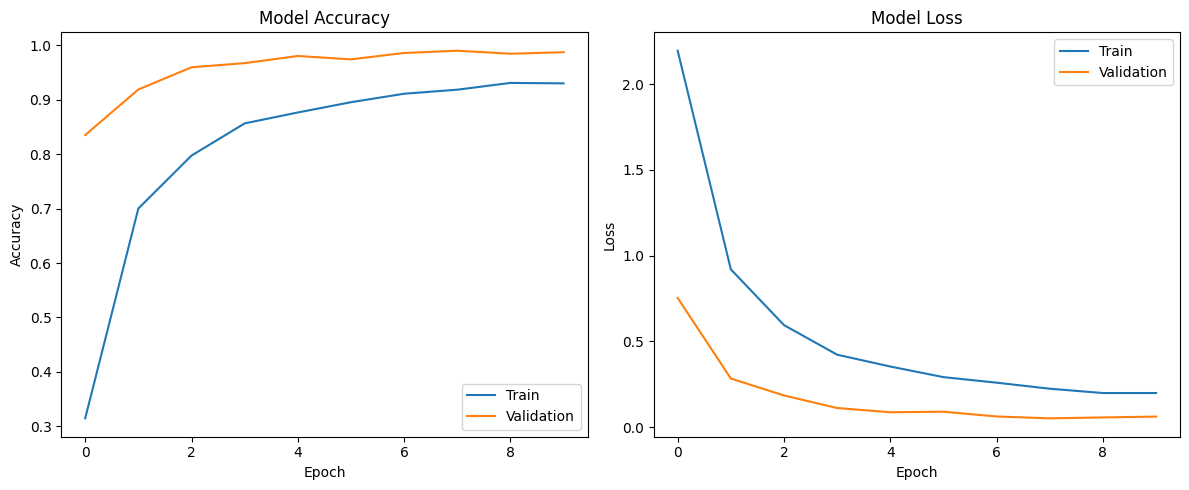

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


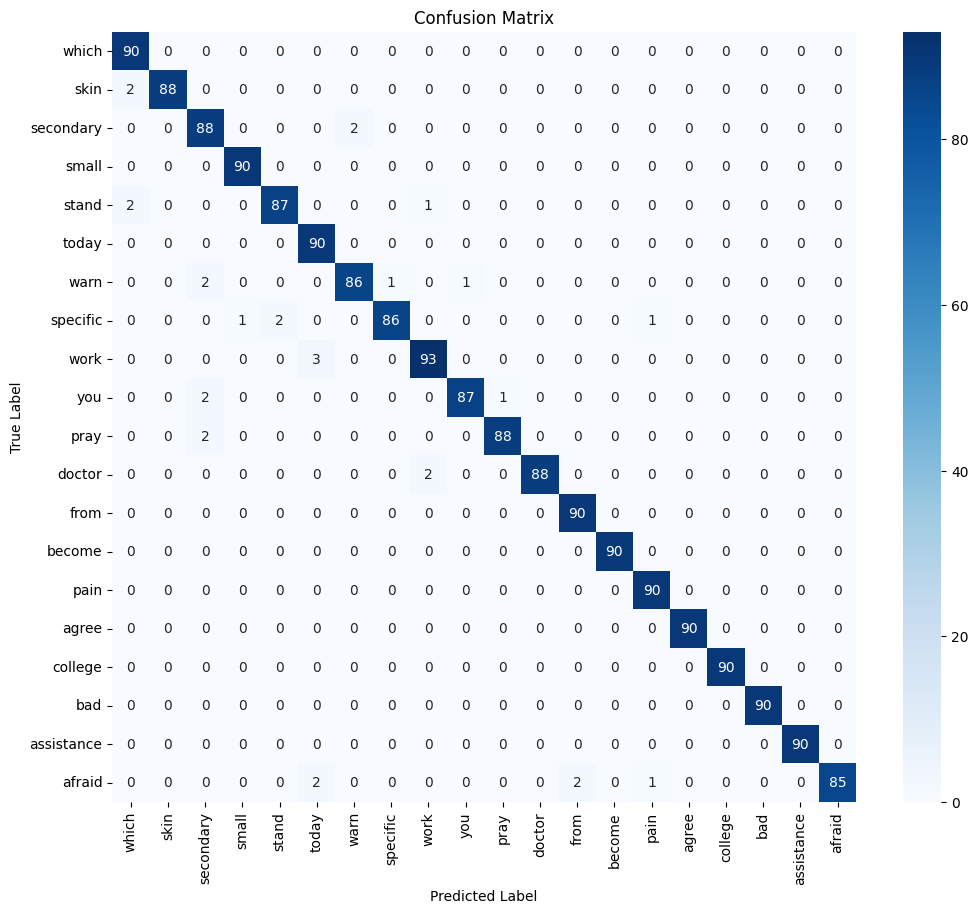

Classification Report:
              precision    recall  f1-score   support

       which       0.96      1.00      0.98        90
        skin       1.00      0.98      0.99        90
   secondary       0.94      0.98      0.96        90
       small       0.99      1.00      0.99        90
       stand       0.98      0.97      0.97        90
       today       0.95      1.00      0.97        90
        warn       0.98      0.96      0.97        90
    specific       0.99      0.96      0.97        90
        work       0.97      0.97      0.97        96
         you       0.99      0.97      0.98        90
        pray       0.99      0.98      0.98        90
      doctor       1.00      0.98      0.99        90
        from       0.98      1.00      0.99        90
      become       1.00      1.00      1.00        90
        pain       0.98      1.00      0.99        90
       agree       1.00      1.00      1.00        90
     college       1.00      1.00      1.00        90
    

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test_categorical)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_history(history)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# Plot confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=categories))

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # For displaying images in Colab

# Load the trained model and category mapping
model = load_model('sign_language_model.h5')

with open('category_mapping.json', 'r') as f:
    category_mapping = json.load(f)
    # Convert keys back to integers
    category_mapping = {int(k): v for k, v in category_mapping.items()}

def preprocess_frame(frame, target_size=(128, 128)):
    """Preprocess a video frame for prediction."""
    # Resize the frame
    frame = cv2.resize(frame, target_size)
    # Convert to RGB (our model was trained on RGB)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Normalize pixel values
    frame = frame / 255.0
    return frame

def extract_frames(video_path, frames_per_word=10):
    """
    Extract frames from video, assuming each word takes approximately the same duration.
    Returns a list of word segments, each containing multiple frames.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return []

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"Video duration: {duration:.2f} seconds")
    print(f"Total frames: {total_frames}")
    print(f"FPS: {fps}")

    # Ask user for the number of words in the video
    try:
        num_words = int(input("Enter the number of words/signs in the video: "))
    except ValueError:
        print("Invalid input. Assuming 1 word.")
        num_words = 1

    # Calculate frames per word
    frames_per_word_segment = total_frames // num_words

    # Extract word segments
    word_segments = []

    for word_idx in range(num_words):
        start_frame = word_idx * frames_per_word_segment
        end_frame = (word_idx + 1) * frames_per_word_segment

        # Cap the number of frames to process per word for efficiency
        step = max(1, (end_frame - start_frame) // frames_per_word)

        word_frames = []

        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for frame_idx in range(start_frame, end_frame, step):
            ret, frame = cap.read()
            if not ret:
                break

            # Preprocess the frame
            processed_frame = preprocess_frame(frame)
            word_frames.append(processed_frame)

            # For demonstration, save some frames
            if len(word_frames) <= 3:  # Save first 3 frames of each word
                save_path = f"word_{word_idx+1}_frame_{len(word_frames)}.jpg"
                cv2.imwrite(save_path, frame)

        if word_frames:
            word_segments.append(word_frames)

    cap.release()

    print(f"Extracted {len(word_segments)} word segments")
    for i, segment in enumerate(word_segments):
        print(f"Word {i+1} has {len(segment)} frames")

    return word_segments

def predict_word_from_frames(frames, model, category_mapping):
    """
    Predict the sign word from a sequence of frames.
    Uses a voting mechanism across frames.
    """
    predictions = []

    for frame in frames:
        # Add batch dimension
        frame_batch = np.expand_dims(frame, axis=0)

        # Get prediction
        pred = model.predict(frame_batch, verbose=0)
        pred_class = np.argmax(pred, axis=1)[0]
        predictions.append(pred_class)

    # Use the most common prediction
    from collections import Counter
    most_common = Counter(predictions).most_common(1)[0][0]

    return category_mapping[most_common]

def process_video(video_path):
    """Process a sign language video and convert it to text."""
    print(f"Processing video: {video_path}")

    # Extract frames
    word_segments = extract_frames(video_path)

    if not word_segments:
        return "No frames could be extracted from the video."

    # Predict each word
    predicted_words = []

    for i, frames in enumerate(word_segments):
        word = predict_word_from_frames(frames, model, category_mapping)
        predicted_words.append(word)
        print(f"Word {i+1}: {word}")

    # Generate a simple gloss sentence
    gloss_sentence = " ".join(predicted_words)
    print(f"Generated gloss sentence: {gloss_sentence}")

    return gloss_sentence

def test_on_sample_videos(video_paths):
    """Test the system on multiple sample videos."""
    for video_path in video_paths:
        print(f"\nTesting on: {video_path}")
        result = process_video(video_path)
        print(f"Result: {result}")
        print("-" * 50)

# Example usage
if __name__ == "__main__":
    # Example with a single video
    video_path = input("Enter the path to your sign language video: ")
    result = process_video(video_path)
    print(f"Final result: {result}")

    # Alternatively, test on multiple videos
    # sample_videos = ['video1.mp4', 'video2.mp4', 'video3.mp4']
    # test_on_sample_videos(sample_videos)

Enter the path to your sign language video: got hurt.MP4
Processing video: got hurt.MP4
Video duration: 3.88 seconds
Total frames: 97
FPS: 25.0
Enter the number of words/signs in the video: 1
Extracted 1 word segments
Word 1 has 11 frames


Word 1: pain
Generated gloss sentence: pain
Final result: pain


Indian Sign Language Image Classifier
Choose an option:
1. Classify a single image
2. Batch process a folder of images
3. Process multiple images into a sentence (comma-separated paths)
4. Process a folder of images into a sentence
5. Process images listed in a text file into a sentence
Your choice (1/2/3/4/5): 3


Model loaded successfully.
Found 20 categories in the mapping.

Enter all image paths separated by commas:
Image paths: which294_User2_294.jpg,college_91_User1_91.jpg,you_280_User2_280.jpg,from_208_User2_208.jpg

Will process 4 images.

Image 1: which294_User2_294.jpg
Prediction: which
Confidence: 0.9952


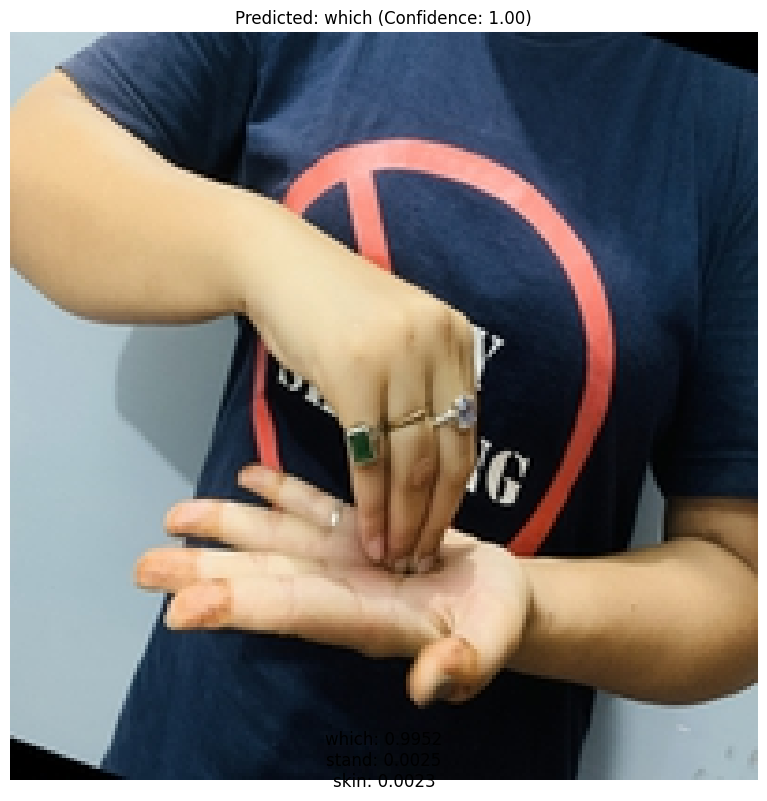


Image 2: college_91_User1_91.jpg
Prediction: college
Confidence: 1.0000


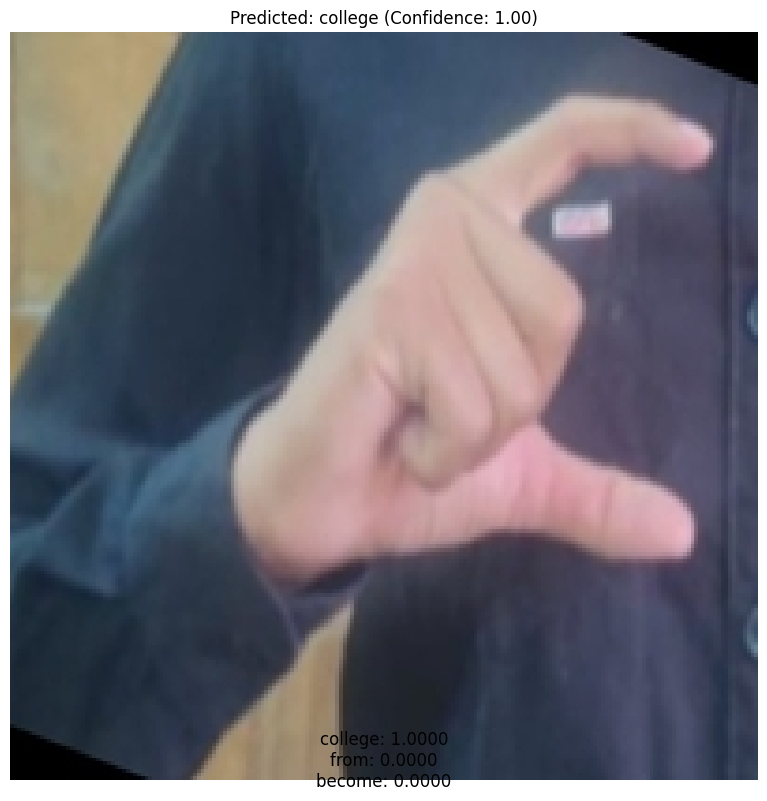


Image 3: you_280_User2_280.jpg
Prediction: you
Confidence: 0.9954


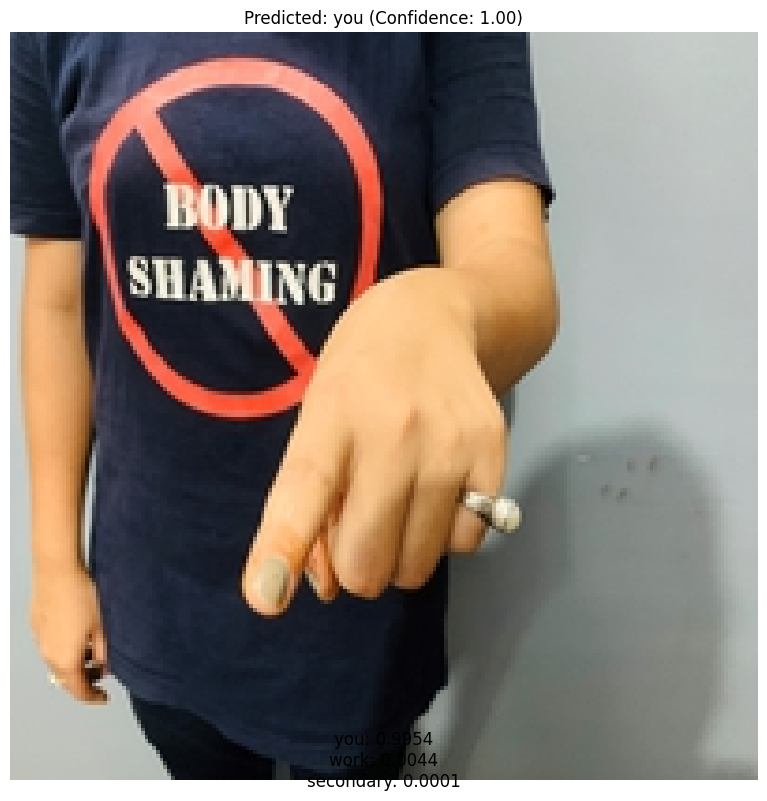


Image 4: from_208_User2_208.jpg
Prediction: from
Confidence: 1.0000


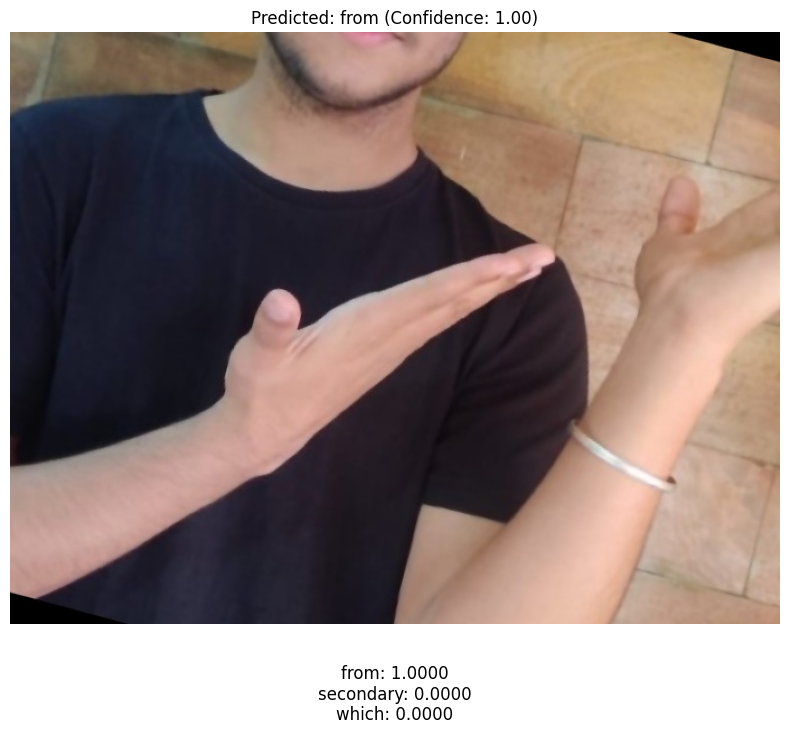


=== FINAL SENTENCE ===
Raw gloss: which college you from
Formatted sentence: Which college you from.


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
import matplotlib.pyplot as plt
import os

def load_model_and_mapping(model_path='sign_language_model.h5', mapping_path='category_mapping.json'):
    """Load the trained model and category mapping."""
    # Load the model
    model = load_model(model_path)

    # Load category mapping
    with open(mapping_path, 'r') as f:
        category_mapping = json.load(f)

    return model, category_mapping

def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocess an image for prediction using the same steps as during training.
    Assumes the input_shape from the model is (height, width, channels).
    """
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Could not read image from {image_path}")

    # Resize the image
    image = cv2.resize(image, target_size)

    # Convert to RGB (since most models are trained on RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to match training
    image = image / 255.0

    return image

def predict_sign(image_path, model, category_mapping):
    """Predict the sign from an image."""
    # Preprocess the image
    processed_image = preprocess_image(image_path)

    # Add batch dimension
    image_batch = np.expand_dims(processed_image, axis=0)

    # Get prediction
    pred = model.predict(image_batch, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = float(pred[0][pred_class])

    # Get the predicted word
    predicted_word = category_mapping[str(pred_class)]  # Keys may be strings in the JSON

    # Get top 3 predictions for additional information
    top_indices = np.argsort(pred[0])[-3:][::-1]
    top_predictions = [(category_mapping[str(idx)], float(pred[0][idx])) for idx in top_indices]

    return predicted_word, confidence, top_predictions

def display_prediction(image_path, predicted_word, confidence, top_predictions=None):
    """Display the image with its prediction."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_word} (Confidence: {confidence:.2f})")

    # Add top predictions as text
    if top_predictions:
        text = "\n".join([f"{label}: {conf:.4f}" for label, conf in top_predictions])
        plt.figtext(0.5, 0.01, text, ha='center', fontsize=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_multiple_images_to_sentence():
    """Process multiple images and combine predictions into a sentence."""
    # Load model and category mapping
    try:
        model, category_mapping = load_model_and_mapping()
        print("Model loaded successfully.")
        print(f"Found {len(category_mapping)} categories in the mapping.")
    except Exception as e:
        print(f"Error loading model or mapping: {e}")
        return

    # Get all image paths at once instead of one by one
    print("\nEnter all image paths separated by commas:")
    image_paths_input = input("Image paths: ")

    # Split the input and strip whitespace
    image_paths = [path.strip() for path in image_paths_input.split(',')]

    # Filter out empty paths
    image_paths = [path for path in image_paths if path]

    if not image_paths:
        print("No valid image paths provided.")
        return

    # Validate all paths before processing
    valid_paths = []
    for path in image_paths:
        if os.path.exists(path):
            valid_paths.append(path)
        else:
            print(f"Warning: File not found at {path}")

    if not valid_paths:
        print("No valid image files found.")
        return

    print(f"\nWill process {len(valid_paths)} images.")

    # Process each image
    sentence_words = []

    for i, image_path in enumerate(valid_paths):
        try:
            # Predict sign
            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)
            sentence_words.append(predicted_word)

            # Display results for individual word
            print(f"\nImage {i+1}: {os.path.basename(image_path)}")
            print(f"Prediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            # Display the image with prediction
            display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    # Combine words into a sentence
    if sentence_words:
        sentence = " ".join(sentence_words)
        print("\n=== FINAL SENTENCE ===")
        print(f"Raw gloss: {sentence}")

        # Capitalize the first letter and add a period
        formatted_sentence = sentence.capitalize() + "."
        print(f"Formatted sentence: {formatted_sentence}")

        return sentence_words, formatted_sentence
    else:
        print("No valid predictions were made.")
        return [], ""

def process_images_with_txt_file():
    """Process images listed in a text file and combine into a sentence."""
    # Load model and category mapping
    try:
        model, category_mapping = load_model_and_mapping()
        print("Model loaded successfully.")
        print(f"Found {len(category_mapping)} categories in the mapping.")
    except Exception as e:
        print(f"Error loading model or mapping: {e}")
        return

    # Get the text file path
    txt_file_path = input("\nEnter the path to a text file containing image paths (one per line): ")

    if not os.path.exists(txt_file_path):
        print(f"Error: File not found at {txt_file_path}")
        return

    # Read image paths from the text file
    try:
        with open(txt_file_path, 'r') as file:
            image_paths = [line.strip() for line in file if line.strip()]
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    if not image_paths:
        print("No image paths found in the file.")
        return

    # Validate all paths before processing
    valid_paths = []
    for path in image_paths:
        if os.path.exists(path):
            valid_paths.append(path)
        else:
            print(f"Warning: File not found at {path}")

    if not valid_paths:
        print("No valid image files found.")
        return

    print(f"\nWill process {len(valid_paths)} images from the file.")

    # Process each image
    sentence_words = []

    for i, image_path in enumerate(valid_paths):
        try:
            # Predict sign
            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)
            sentence_words.append(predicted_word)

            # Display results for individual word
            print(f"\nImage {i+1}: {os.path.basename(image_path)}")
            print(f"Prediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            # Display the image with prediction
            display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    # Combine words into a sentence
    if sentence_words:
        sentence = " ".join(sentence_words)
        print("\n=== FINAL SENTENCE ===")
        print(f"Raw gloss: {sentence}")

        # Capitalize the first letter and add a period
        formatted_sentence = sentence.capitalize() + "."
        print(f"Formatted sentence: {formatted_sentence}")

        return sentence_words, formatted_sentence
    else:
        print("No valid predictions were made.")
        return [], ""

def process_folder_to_sentence(folder_path, display_images=True):
    """Process all images in a folder in sorted order and combine into a sentence."""
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory")
        return [], ""

    # Load model and category mapping
    try:
        model, category_mapping = load_model_and_mapping()
        print("Model loaded successfully.")
        print(f"Found {len(category_mapping)} categories in the mapping.")
    except Exception as e:
        print(f"Error loading model or mapping: {e}")
        return [], ""

    # Get all image files and sort them
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Try to sort naturally if the files are numbered
    try:
        # This sorts "1.jpg", "2.jpg", "10.jpg" correctly
        image_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))) if any(c.isdigit() for c in f) else f)
    except:
        # Fall back to regular sorting if natural sort fails
        image_files.sort()

    sentence_words = []

    print(f"\nProcessing {len(image_files)} images from folder: {folder_path}")

    # Process each image
    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        try:
            # Predict sign
            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)
            sentence_words.append(predicted_word)

            # Display results for individual word
            print(f"\nImage {i+1}: {filename}")
            print(f"Prediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            # Display the image with prediction if requested
            if display_images:
                display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    # Combine words into a sentence
    if sentence_words:
        sentence = " ".join(sentence_words)
        print("\n=== FINAL SENTENCE ===")
        print(f"Raw gloss: {sentence}")

        # Capitalize the first letter and add a period
        formatted_sentence = sentence.capitalize() + "."
        print(f"Formatted sentence: {formatted_sentence}")

        return sentence_words, formatted_sentence
    else:
        print("No valid predictions were made.")
        return [], ""

def batch_predict(image_folder, model, category_mapping, output_file=None):
    """Process all images in a folder."""
    if not os.path.isdir(image_folder):
        print(f"Error: {image_folder} is not a valid directory")
        return

    results = []

    print(f"Processing images in folder: {image_folder}")

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            try:
                predicted_word, confidence, _ = predict_sign(image_path, model, category_mapping)
                results.append((filename, predicted_word, confidence))
                print(f"File: {filename}, Prediction: {predicted_word}, Confidence: {confidence:.4f}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Save results to file if requested
    if output_file:
        with open(output_file, 'w') as f:
            f.write("Filename,Prediction,Confidence\n")
            for filename, word, conf in results:
                f.write(f"{filename},{word},{conf:.4f}\n")
        print(f"Results saved to {output_file}")

    return results

def main():
    print("Indian Sign Language Image Classifier")
    print("====================================")

    choice = input("Choose an option:\n" +
                  "1. Classify a single image\n" +
                  "2. Batch process a folder of images\n" +
                  "3. Process multiple images into a sentence (comma-separated paths)\n" +
                  "4. Process a folder of images into a sentence\n" +
                  "5. Process images listed in a text file into a sentence\n" +
                  "Your choice (1/2/3/4/5): ")

    if choice == '1':
        # Single image classification (original functionality)
        try:
            model, category_mapping = load_model_and_mapping()
            print("Model loaded successfully.")

            image_path = input("\nEnter the path to your sign language image: ")
            if not os.path.exists(image_path):
                print(f"Error: File not found at {image_path}")
                return

            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)

            # Display results
            print(f"\nPrediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            print("\nTop 3 predictions:")
            for label, conf in top_predictions:
                print(f"- {label}: {conf:.4f}")

            # Display the image with prediction
            display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image: {e}")

    elif choice == '2':
        # Batch processing (original functionality)
        try:
            model, category_mapping = load_model_and_mapping()
            folder_path = input("Enter the folder path containing sign language images: ")
            output_file = input("Enter output CSV file name (leave blank for no file output): ")
            output_file = output_file if output_file.strip() else None
            batch_predict(folder_path, model, category_mapping, output_file)
        except Exception as e:
            print(f"Error: {e}")

    elif choice == '3':
        # Process multiple images into a sentence (updated functionality)
        process_multiple_images_to_sentence()

    elif choice == '4':
        # Process a folder of images into a sentence
        folder_path = input("Enter the folder path containing sign language images: ")
        display_choice = input("Display each image with prediction? (y/n): ").lower()
        display_images = display_choice == 'y'
        process_folder_to_sentence(folder_path, display_images)

    elif choice == '5':
        # Process images listed in a text file
        process_images_with_txt_file()

    else:
        print("Invalid choice. Exiting.")

if __name__ == "__main__":
    main()

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
import matplotlib.pyplot as plt
import os

def load_model_and_mapping(model_path='sign_language_model.h5', mapping_path='category_mapping.json'):
    """Load the trained model and category mapping."""
    # Load the model
    model = load_model(model_path)

    # Load category mapping
    with open(mapping_path, 'r') as f:
        category_mapping = json.load(f)

    return model, category_mapping

def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocess an image for prediction using the same steps as during training.
    Assumes the input_shape from the model is (height, width, channels).
    """
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Could not read image from {image_path}")

    # Resize the image
    image = cv2.resize(image, target_size)

    # Convert to RGB (since most models are trained on RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to match training
    image = image / 255.0

    return image

def predict_sign(image_path, model, category_mapping):
    """Predict the sign from an image."""
    # Preprocess the image
    processed_image = preprocess_image(image_path)

    # Add batch dimension
    image_batch = np.expand_dims(processed_image, axis=0)

    # Get prediction
    pred = model.predict(image_batch, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = float(pred[0][pred_class])

    # Get the predicted word
    predicted_word = category_mapping[str(pred_class)]  # Keys may be strings in the JSON

    # Get top 3 predictions for additional information
    top_indices = np.argsort(pred[0])[-3:][::-1]
    top_predictions = [(category_mapping[str(idx)], float(pred[0][idx])) for idx in top_indices]

    return predicted_word, confidence, top_predictions

def display_prediction(image_path, predicted_word, confidence, top_predictions=None):
    """Display the image with its prediction."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_word} (Confidence: {confidence:.2f})")

    # Add top predictions as text
    if top_predictions:
        text = "\n".join([f"{label}: {conf:.4f}" for label, conf in top_predictions])
        plt.figtext(0.5, 0.01, text, ha='center', fontsize=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

def process_multiple_images_to_sentence():
    """Process multiple images and combine predictions into a sentence."""
    # Load model and category mapping
    try:
        model, category_mapping = load_model_and_mapping()
        print("Model loaded successfully.")
        print(f"Found {len(category_mapping)} categories in the mapping.")
    except Exception as e:
        print(f"Error loading model or mapping: {e}")
        return

    # Get all image paths at once instead of one by one
    print("\nEnter all image paths separated by commas:")
    image_paths_input = input("Image paths: ")

    # Split the input and strip whitespace
    image_paths = [path.strip() for path in image_paths_input.split(',')]

    # Filter out empty paths
    image_paths = [path for path in image_paths if path]

    if not image_paths:
        print("No valid image paths provided.")
        return

    # Validate all paths before processing
    valid_paths = []
    for path in image_paths:
        if os.path.exists(path):
            valid_paths.append(path)
        else:
            print(f"Warning: File not found at {path}")

    if not valid_paths:
        print("No valid image files found.")
        return

    print(f"\nWill process {len(valid_paths)} images.")

    # Process each image
    sentence_words = []

    for i, image_path in enumerate(valid_paths):
        try:
            # Predict sign
            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)
            sentence_words.append(predicted_word)

            # Display results for individual word
            print(f"\nImage {i+1}: {os.path.basename(image_path)}")
            print(f"Prediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            # Display the image with prediction
            display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    # Combine words into a sentence
    if sentence_words:
        sentence = " ".join(sentence_words)
        print("\n=== FINAL SENTENCE ===")
        print(f"Raw gloss: {sentence}")

        # Capitalize the first letter and add a period
        formatted_sentence = sentence.capitalize() + "."
        print(f"Formatted sentence: {formatted_sentence}")
        
        # Generate video name from the gloss
        video_name = "_".join(sentence_words).upper() + ".mp4"
        print(f"Video name: {video_name}")

        return sentence_words, formatted_sentence
    else:
        print("No valid predictions were made.")
        return [], ""

def process_images_with_txt_file():
    """Process images listed in a text file and combine into a sentence."""
    # Load model and category mapping
    try:
        model, category_mapping = load_model_and_mapping()
        print("Model loaded successfully.")
        print(f"Found {len(category_mapping)} categories in the mapping.")
    except Exception as e:
        print(f"Error loading model or mapping: {e}")
        return

    # Get the text file path
    txt_file_path = input("\nEnter the path to a text file containing image paths (one per line): ")

    if not os.path.exists(txt_file_path):
        print(f"Error: File not found at {txt_file_path}")
        return

    # Read image paths from the text file
    try:
        with open(txt_file_path, 'r') as file:
            image_paths = [line.strip() for line in file if line.strip()]
    except Exception as e:
        print(f"Error reading file: {e}")
        return

    if not image_paths:
        print("No image paths found in the file.")
        return

    # Validate all paths before processing
    valid_paths = []
    for path in image_paths:
        if os.path.exists(path):
            valid_paths.append(path)
        else:
            print(f"Warning: File not found at {path}")

    if not valid_paths:
        print("No valid image files found.")
        return

    print(f"\nWill process {len(valid_paths)} images from the file.")

    # Process each image
    sentence_words = []

    for i, image_path in enumerate(valid_paths):
        try:
            # Predict sign
            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)
            sentence_words.append(predicted_word)

            # Display results for individual word
            print(f"\nImage {i+1}: {os.path.basename(image_path)}")
            print(f"Prediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            # Display the image with prediction
            display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    # Combine words into a sentence
    if sentence_words:
        sentence = " ".join(sentence_words)
        print("\n=== FINAL SENTENCE ===")
        print(f"Raw gloss: {sentence}")

        # Capitalize the first letter and add a period
        formatted_sentence = sentence.capitalize() + "."
        print(f"Formatted sentence: {formatted_sentence}")
        
        # Generate video name from the gloss
        video_name = "_".join(sentence_words).upper() + ".mp4"
        print(f"Video name: {video_name}")

        return sentence_words, formatted_sentence
    else:
        print("No valid predictions were made.")
        return [], ""

def process_folder_to_sentence(folder_path, display_images=True):
    """Process all images in a folder in sorted order and combine into a sentence."""
    if not os.path.isdir(folder_path):
        print(f"Error: {folder_path} is not a valid directory")
        return [], ""

    # Load model and category mapping
    try:
        model, category_mapping = load_model_and_mapping()
        print("Model loaded successfully.")
        print(f"Found {len(category_mapping)} categories in the mapping.")
    except Exception as e:
        print(f"Error loading model or mapping: {e}")
        return [], ""

    # Get all image files and sort them
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Try to sort naturally if the files are numbered
    try:
        # This sorts "1.jpg", "2.jpg", "10.jpg" correctly
        image_files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))) if any(c.isdigit() for c in f) else f)
    except:
        # Fall back to regular sorting if natural sort fails
        image_files.sort()

    sentence_words = []

    print(f"\nProcessing {len(image_files)} images from folder: {folder_path}")

    # Process each image
    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        try:
            # Predict sign
            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)
            sentence_words.append(predicted_word)

            # Display results for individual word
            print(f"\nImage {i+1}: {filename}")
            print(f"Prediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            # Display the image with prediction if requested
            if display_images:
                display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    # Combine words into a sentence
    if sentence_words:
        sentence = " ".join(sentence_words)
        print("\n=== FINAL SENTENCE ===")
        print(f"Raw gloss: {sentence}")

        # Capitalize the first letter and add a period
        formatted_sentence = sentence.capitalize() + "."
        print(f"Formatted sentence: {formatted_sentence}")
        
        # Generate video name from the gloss
        video_name = "_".join(sentence_words).upper() + ".mp4"
        print(f"Video name: {video_name}")

        return sentence_words, formatted_sentence
    else:
        print("No valid predictions were made.")
        return [], ""

def batch_predict(image_folder, model, category_mapping, output_file=None):
    """Process all images in a folder."""
    if not os.path.isdir(image_folder):
        print(f"Error: {image_folder} is not a valid directory")
        return

    results = []

    print(f"Processing images in folder: {image_folder}")

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, filename)
            try:
                predicted_word, confidence, _ = predict_sign(image_path, model, category_mapping)
                results.append((filename, predicted_word, confidence))
                print(f"File: {filename}, Prediction: {predicted_word}, Confidence: {confidence:.4f}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # Save results to file if requested
    if output_file:
        with open(output_file, 'w') as f:
            f.write("Filename,Prediction,Confidence\n")
            for filename, word, conf in results:
                f.write(f"{filename},{word},{conf:.4f}\n")
        print(f"Results saved to {output_file}")

    return results

def main():
    print("Indian Sign Language Image Classifier")
    print("====================================")

    choice = input("Choose an option:\n" +
                  "1. Classify a single image\n" +
                  "2. Batch process a folder of images\n" +
                  "3. Process multiple images into a sentence (comma-separated paths)\n" +
                  "4. Process a folder of images into a sentence\n" +
                  "5. Process images listed in a text file into a sentence\n" +
                  "Your choice (1/2/3/4/5): ")

    if choice == '1':
        # Single image classification (original functionality)
        try:
            model, category_mapping = load_model_and_mapping()
            print("Model loaded successfully.")

            image_path = input("\nEnter the path to your sign language image: ")
            if not os.path.exists(image_path):
                print(f"Error: File not found at {image_path}")
                return

            predicted_word, confidence, top_predictions = predict_sign(image_path, model, category_mapping)

            # Display results
            print(f"\nPrediction: {predicted_word}")
            print(f"Confidence: {confidence:.4f}")

            print("\nTop 3 predictions:")
            for label, conf in top_predictions:
                print(f"- {label}: {conf:.4f}")

            # Display the image with prediction
            display_prediction(image_path, predicted_word, confidence, top_predictions)

        except Exception as e:
            print(f"Error processing image: {e}")

    elif choice == '2':
        # Batch processing (original functionality)
        try:
            model, category_mapping = load_model_and_mapping()
            folder_path = input("Enter the folder path containing sign language images: ")
            output_file = input("Enter output CSV file name (leave blank for no file output): ")
            output_file = output_file if output_file.strip() else None
            batch_predict(folder_path, model, category_mapping, output_file)
        except Exception as e:
            print(f"Error: {e}")

    elif choice == '3':
        # Process multiple images into a sentence (updated functionality)
        process_multiple_images_to_sentence()

    elif choice == '4':
        # Process a folder of images into a sentence
        folder_path = input("Enter the folder path containing sign language images: ")
        display_choice = input("Display each image with prediction? (y/n): ").lower()
        display_images = display_choice == 'y'
        process_folder_to_sentence(folder_path, display_images)

    elif choice == '5':
        # Process images listed in a text file
        process_images_with_txt_file()

    else:
        print("Invalid choice. Exiting.")

if __name__ == "__main__":
    main()